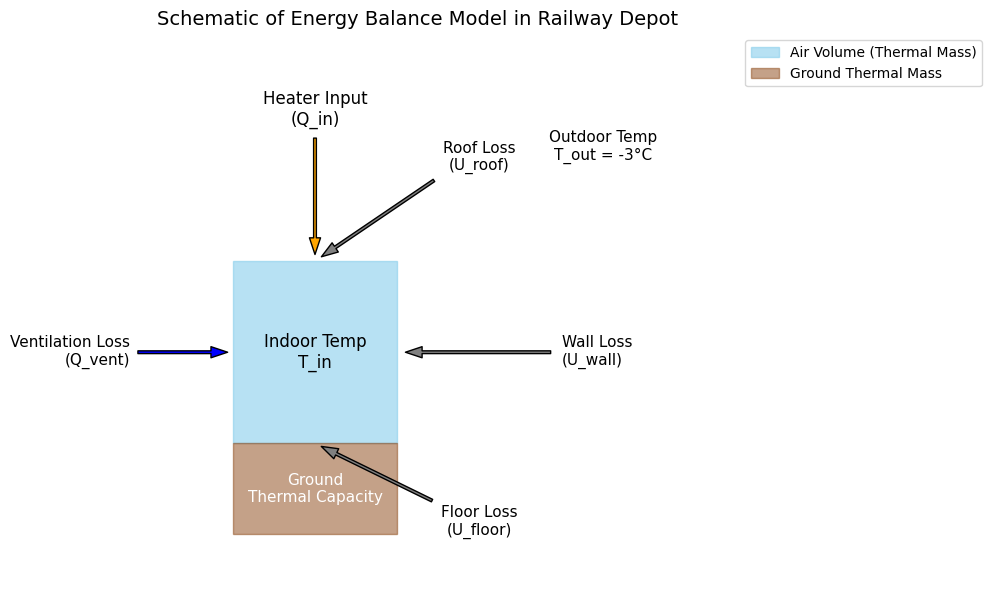

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create schematic plot
fig, ax = plt.subplots(figsize=(10, 6))

# Air volume block
air_box = plt.Rectangle((0.3, 0.3), 0.4, 0.4, color='skyblue', label='Air Volume (Thermal Mass)', alpha=0.6)
ax.add_patch(air_box)

# Ground thermal capacity block
ground_block = plt.Rectangle((0.3, 0.1), 0.4, 0.2, color='saddlebrown', label='Ground Thermal Mass', alpha=0.5)
ax.add_patch(ground_block)
ax.text(0.5, 0.2, 'Ground\nThermal Capacity', ha='center', va='center', fontsize=11, color='white')

# Heat input (radiant panel)
ax.annotate('Heater Input\n(Q_in)', xy=(0.5, 0.7), xytext=(0.5, 1.0),
            arrowprops=dict(facecolor='orange', shrink=0.05, width=2, headwidth=8),
            ha='center', fontsize=12)

# Heat loss through walls
ax.annotate('Wall Loss\n(U_wall)', xy=(0.7, 0.5), xytext=(1.1, 0.5),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
            va='center', fontsize=11)

# Heat loss through roof
ax.annotate('Roof Loss\n(U_roof)', xy=(0.5, 0.7), xytext=(0.9, 0.9),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
            ha='center', fontsize=11)

# Heat loss through floor
ax.annotate('Floor Loss\n(U_floor)', xy=(0.5, 0.3), xytext=(0.9, 0.1),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
            ha='center', fontsize=11)

# Ventilation loss arrow
ax.annotate('Ventilation Loss\n(Q_vent)', xy=(0.3, 0.5), xytext=(0.05, 0.5),
            arrowprops=dict(facecolor='blue', shrink=0.05, width=2, headwidth=8),
            va='center', ha='right', fontsize=11)

# Indoor temperature label
ax.text(0.5, 0.5, 'Indoor Temp\nT_in', ha='center', va='center', fontsize=12, color='black')

# Outdoor temperature label
ax.text(1.2, 0.95, 'Outdoor Temp\nT_out = -3°C', ha='center', va='center', fontsize=11, color='black')

# Axis settings
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.2)
ax.axis('off')

# Title and legend
plt.title('Schematic of Energy Balance Model in Railway Depot', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
plt.tight_layout()
plt.show()



### Ground Thermal Capacity
Determine value for `ground_thermal_capacity`

To calculate it from first principles: 

$$C_{ground} = m_{ground} \cdot c_{p, soil}$$

Where:
* $C_{ground}$ is the thermal capacity of the ground in $J/K$.
* $m_{ground}$ is the mass of the soil (in kg) that is thermally coupled with the building. This is the hardest value to determine, as it requires knowing the effective depth of heat penetration into the ground over the simulation time.
* $c_{p, soil}$ is the specific heat capacity of the soil (you correctly note a typical value is around $1000 \, J/(kg \cdot K)$).

For context, if we assume an effective depth of just $0.5 \, m$ of soil beneath the depot floor ($3800 \, m^2$) with a typical soil density of $1500 \, kg/m^3$:

* **Volume:** $3800 \, m^2 \times 0.5 \, m = 1900 \, m^3$
* **Mass:** $1900 \, m^3 \times 1500 \, kg/m^3 = 2.85 \times 10^6 \, kg$
* **Calculated Thermal Capacity:** $2.85 \times 10^6 \, kg \times 1000 \, J/(kg \cdot K) = 2.85 \times 10^9 \, J/K$


### The Mathematical Model
The code numerically solves a **first-order ordinary differential equation (ODE)** that describes the energy balance of the depot. The fundamental principle is the first law of thermodynamics: the change in the internal energy of the system is equal to the net heat added to the system.

The core equation for the indoor temperature ($T_{in}$) over time ($t$) is:

$$\frac{dT_{in}}{dt} = \frac{Q_{net}}{C_{total}}$$

#### 1. Total Thermal Capacity ($C_{total}$)

This represents the system's resistance to temperature change. In the model, it's the sum of the thermal capacity of the air and the ground.

$$C_{total} = C_{air} + C_{ground}$$

* **Air Thermal Capacity ($C_{air}$):** Calculated as the product of the air's volume ($V_{air}$), density ($\rho_{air}$), and specific heat capacity ($c_{p,air}$).
    $$C_{air} = V_{air} \cdot \rho_{air} \cdot c_{p,air}$$
* **Ground Thermal Capacity ($C_{ground}$):** The assumed value discussed above.

#### 2. Net Heat Flow Rate ($Q_{net}$)

This is the rate at which energy is added to the system (in Watts, or Joules per second). It's the difference between the heat generated by the panels and the heat lost to the environment.

$$Q_{net} = Q_{panels} - Q_{loss}$$

* **Heating Power ($Q_{panels}$):** The heat supplied by the panels.
    $$Q_{panels} = N_{panels} \cdot P_{panel}$$
* **Total Heat Loss ($Q_{loss}$):** The sum of heat loss from conduction (through the building envelope) and ventilation (air exchange).
    $$Q_{loss} = Q_{conduction} + Q_{ventilation}$$

#### 3. Heat Loss Mechanisms

Heat loss is driven by the temperature difference between the inside and outside, $\Delta T = T_{in} - T_{out}$.

* **Conduction Loss ($Q_{conduction}$):** Heat transfer through the building's surfaces (walls, windows, etc.). It is calculated by summing the heat flow through each component, governed by its area ($A$) and U-value ($U$).
    $$Q_{conduction} = (\sum_{i} U_i A_i) \cdot \Delta T$$
    The code sums the contributions from solid walls, windows, shutters, the roof, and the floor.
    $$\sum U_i A_i = (U_{solid}A_{solid} + U_{win}A_{win} + U_{shut}A_{shut} + U_{roof}A_{roof} + U_{floor}A_{floor})$$

* **Ventilation Loss ($Q_{ventilation}$):** Heat lost by replacing warm indoor air with cold outdoor air.
    $$Q_{ventilation} = \dot{m}_{air} \cdot c_{p,air} \cdot \Delta T$$
    Where the mass flow rate of air ($\dot{m}_{air}$) is determined by the Air Changes per Hour (ACH) and the building volume ($V_{air}$).
    $$\dot{m}_{air} = \frac{ACH \cdot V_{air}}{3600} \cdot \rho_{air}$$

#### 4. Numerical Solution

The code does not solve the differential equation analytically. Instead, it uses the **Euler method**, a numerical technique to approximate the solution over discrete time steps ($\Delta t$). The temperature at the next time step ($T_{t+1}$) is found from the temperature at the current time step ($T_t$):

$$T_{t+1} = T_t + \Delta T_{in}$$

Where the change in temperature is calculated as:

$$\Delta T_{in} = \frac{Q_{net} \cdot \Delta t}{C_{total}}$$

This is exactly what your `for` loop implements:
`temps[t] = temps[t-1] + (net_heat * time_step) / total_thermal_capacity`

This is a valid and common approach for this type of thermal simulation.

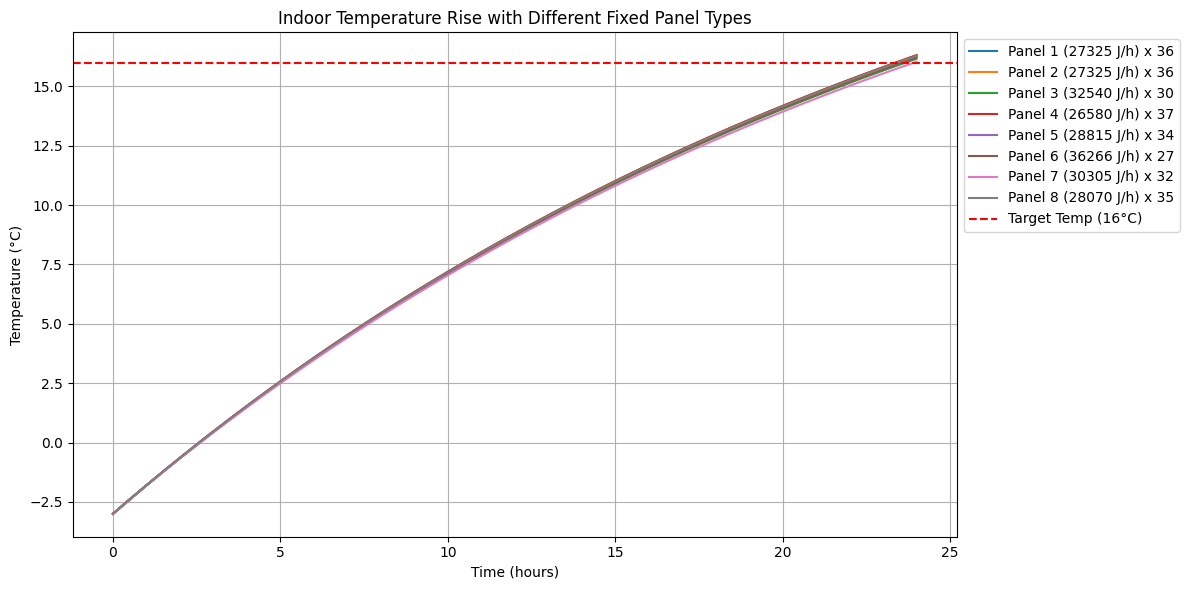

Heating Panel Summary:
- Panel 1 (27325 J/h): Panels needed = 36
- Panel 2 (27325 J/h): Panels needed = 36
- Panel 3 (32540 J/h): Panels needed = 30
- Panel 4 (26580 J/h): Panels needed = 37
- Panel 5 (28815 J/h): Panels needed = 34
- Panel 6 (36266 J/h): Panels needed = 27
- Panel 7 (30305 J/h): Panels needed = 32
- Panel 8 (28070 J/h): Panels needed = 35


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Depot dimensions

length = 100.0        # m
width = 38.0          # m
height = 0.5*(8.5+5.8)         # m

wall_area_total = 2 * height * (length + width)  # m²
# Wall breakdown
side_wall_area = height * length  # each long side
window_area = 0.5 * side_wall_area * 2  # 50% of both long sides
shutter_area = 22.5  # total 22.5 m²
solid_wall_area = wall_area_total - window_area - shutter_area

# U-values
U_solid_wall = 1.6      # W/(m²·K) Cavity wall, no insulation
U_window = 5.0          # W/(m²·K) Single glazed
U_shutter = 4.5         # W/(m²·K)
U_roof = 5.0            # W/(m²·K) Perspex/Glass
U_floor = 1.5           # W/(m²·K)  # (Assumed, update if you have a value)

roof_area = length * width                 # m²
floor_area = roof_area                     # m²

# Temperature setup
inside_temp_target = 16.0    # °C
initial_inside_temp = -3.0   # °C
outside_temp = -3.0          # °C

# Heating panels (Energy per hour in J)
panel_single_energy = [27325,27325,32540,26580,28815,36266,30305,28070]  # W 
# panel references: 1,2,3,4,5,6,7,8
ref_panel_names = [
    "Panel 1 (27325 J/h)", 
    "Panel 2 (27325 J/h)", 
    "Panel 3 (32540 J/h)", 
    "Panel 4 (26580 J/h)", 
    "Panel 5 (28815 J/h)", 
    "Panel 6 (36266 J/h)", 
    "Panel 7 (30305 J/h)", 
    "Panel 8 (28070 J/h)"
]

# Ground & air thermal properties
include_ground = True
ground_thermal_capacity = 2.85e9 # J/K, A typical value for the specific heat capacity of soil is 1000 J/kg K, 

air_density = 1.225         # kg/m³
specific_heat_air = 1005    # J/(kg·K)

# Ventilation
enable_ventilation = False  # not decided yet !
air_change_rate_per_hour = 0.5  # ACH

# Simulation time
time_step = 600  # seconds
total_simulation_time = 24 * 3600  # 24 hours
time_steps = int(total_simulation_time / time_step)
time = np.linspace(0, total_simulation_time, time_steps) / 3600  # in hours

# DERIVED PARAMETERS

volume_air = height * width * length  # m³
thermal_capacity_air = volume_air * air_density * specific_heat_air  # J/K
total_thermal_capacity = thermal_capacity_air + (ground_thermal_capacity if include_ground else 0)

# FUNCTIONS
def calculate_heat_loss(delta_T):
    wall_loss = (
        solid_wall_area * U_solid_wall +
        window_area * U_window +
        shutter_area * U_shutter
    ) * delta_T
    roof_loss = roof_area * U_roof * delta_T
    floor_loss = floor_area * U_floor * delta_T
    return wall_loss + roof_loss + floor_loss

def calculate_ventilation_loss(delta_T):
    if not enable_ventilation:
        return 0.0
    air_flow_rate = (air_change_rate_per_hour * volume_air) / 3600  # m³/s
    return air_density * specific_heat_air * air_flow_rate * delta_T  # W

def simulate_heating(panel_power):
    temps = np.zeros(time_steps)
    temps[0] = initial_inside_temp

    for t in range(1, time_steps):
        delta_T = temps[t-1] - outside_temp
        heat_loss = calculate_heat_loss(delta_T) + calculate_ventilation_loss(delta_T)
        net_heat = panel_power - heat_loss
        temps[t] = temps[t-1] + (net_heat * time_step) / total_thermal_capacity
    return temps

# MAIN CALCULATION LOOP

panel_results = []
for idx, panel_power in enumerate(panel_single_energy):
    min_panels = 1
    max_panels = 50
    found = False
    for num_panels in range(min_panels, max_panels + 1):
        total_power = panel_power * num_panels
        temperature_profile = simulate_heating(total_power)
        final_temp = temperature_profile[-1]
        if final_temp >= inside_temp_target:
            panel_results.append({
                'panel_type': ref_panel_names[idx],  # Use ref_panel_names here
                'num_panels': num_panels,
                'temperature_profile': temperature_profile
            })
            found = True
            break
    if not found:
        panel_results.append({
            'panel_type': ref_panel_names[idx],  # Use ref_panel_names here
            'num_panels': 'Not sufficient (max limit reached)',
            'temperature_profile': None
        })

# RESULTS AND PLOTS

plt.figure(figsize=(12, 6))
for result in panel_results:
    if result['temperature_profile'] is not None:
        plt.plot(time, result['temperature_profile'], label=f"{result['panel_type']} x {result['num_panels']}")
    else:
        print(f"{result['panel_type']}: Insufficient heating even with 200 panels.")

plt.axhline(inside_temp_target, color='red', linestyle='--', label='Target Temp (16°C)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.title('Indoor Temperature Rise with Different Fixed Panel Types')
# legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================
# TEXTUAL SUMMARY
# ========================

print("Heating Panel Summary:")
for result in panel_results:
    print(f"- {result['panel_type']}: Panels needed = {result['num_panels']}")
